In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from keras.layers import Input, Reshape, Conv2D, Dense, Dropout, Flatten, UpSampling2D
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.initializers import normal

Using TensorFlow backend.


In [2]:
np.random.seed(2332)

randomDim = 100

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:,:,:,np.newaxis]

In [4]:
X_train.shape

(60000, 28, 28, 1)

In [5]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [6]:
## generator

generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer='normal'))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D((2,2)))
generator.add(Conv2D(64, (5,5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D((2,2)))
generator.add(Conv2D(1, (5,5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [7]:
## disciminator

disciminator = Sequential()
disciminator.add(Conv2D(64, (5,5), padding='same', strides=(2,2), kernel_initializer='normal'))
disciminator.add(LeakyReLU(0.2))
disciminator.add(Dropout(0.25))
disciminator.add(Conv2D(128, (5,5), padding='same', strides=(2,2), kernel_initializer='normal'))
disciminator.add(LeakyReLU(0.2))
disciminator.add(Dropout(0.25))
disciminator.add(Flatten())
disciminator.add(Dense(100, activation='relu'))
disciminator.add(Dense(1, activation='sigmoid'))
disciminator.compile(loss='binary_crossentropy', optimizer=adam)

In [8]:
## Combined Network

disciminator.trainable = False
ganInp = Input(shape=(randomDim,))
x = generator(ganInp)
ganOut = disciminator(x)

gan = Model(inputs = ganInp, outputs=ganOut)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [9]:
glosses = []
dlosses = []

In [10]:
def plotLoss(epoch):
    plt.figure(figsize=(8,10))
    plt.plot(dlosses, label="Discrinimator loss")
    plt.plot(glosses, label="Generator loss")
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' %epoch)

In [11]:
def plotGeneratedImages(epoch,example=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[example, randomDim])
    genImages = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(genImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(genImages[i,0],interpolation='nearest', cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_images_%d.png' %epoch)

In [12]:
def train(epochs=1, batchsize=128):
    batchCount = X_train.shape[0]//batchsize
    print ("Epochs : %d" % epochs)
    print ("BatchSize : %d" % batchsize)
    print ("Batches per epoch : %d" % batchCount)
    
    for e in range(1,epochs+1):
        print ("-"*20 , "Epoch : %d" % e, "-"*20)
        
        for _ in tqdm(range(batchCount)):
            
            noise = np.random.normal(0, 1, size=[batchsize, randomDim])
            imgBatch = X_train[np.random.randint(0,X_train.shape[0], size=batchsize)]
            genImages = generator.predict(noise)
            
            X = np.concatenate([imgBatch,genImages])
            yDis = np.zeros(2*batchsize)
            
            yDis[:batchsize] = 0.9
            
            ## train discriminator
            disciminator.trainable = True
            dloss = disciminator.train_on_batch(X, yDis)
            
            # train generator
            noise = np.random.normal(0, 1, size=[batchsize, randomDim])
            yGen = np.ones(batchsize)
            disciminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            
        dlosses.append(dloss)
        glosses.append(gloss)
        
        if e==1 or e % 50 == 0:
            plotGeneratedImages(e)
        
        plotLoss(e)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs : 100
BatchSize : 128
Batches per epoch : 468
('--------------------', 'Epoch : 1', '--------------------')


  0%|          | 0/468 [00:00<?, ?it/s]

('--------------------', 'Epoch : 2', '--------------------')


 43%|████▎     | 203/468 [09:27<13:12,  2.99s/it]

KeyboardInterrupt: 

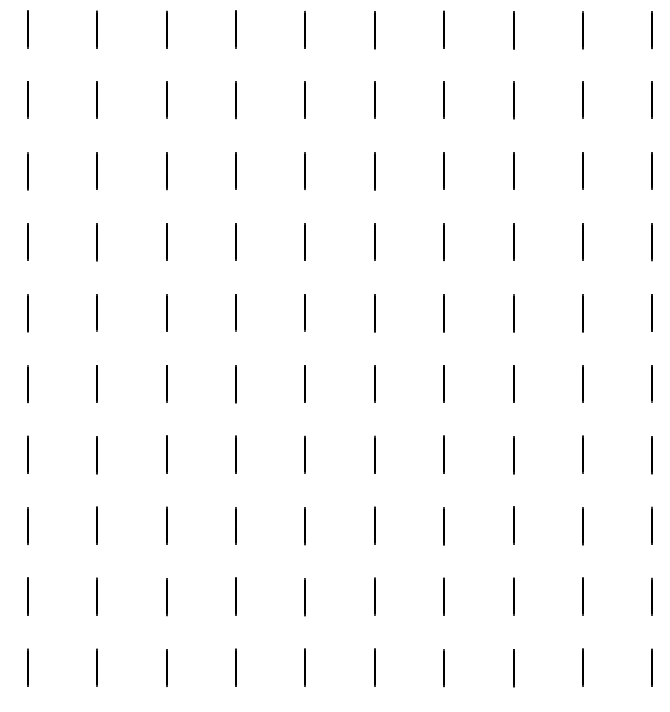

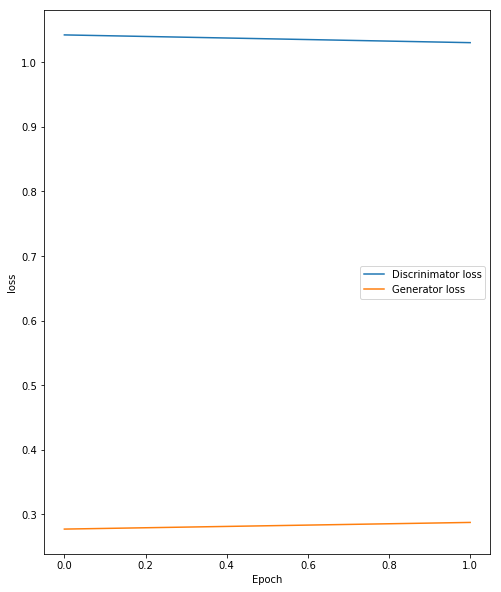

In [14]:
train(100,128)